In [ ]:
import sqlite3
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import logging
import numpy as np


conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select sum(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration, data_time.date, attendances * 10000 / commune.population from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'concentration', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])
data = data.drop(columns=['date'])

# scale
scaler = StandardScaler()
data[['concentration']] = scaler.fit_transform(data[['concentration']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

,commune,concentration,attendances
date,,,
2018-01-01,LA CISTERNA,0.318082,0.301024
2018-01-01,PENALOLEN,-1.227433,0.614815
2018-01-01,PUENTE ALTO,0.839011,0.824010
2018-01-01,TALAGANTE,-1.602993,-0.849545
2018-02-01,LA CISTERNA,-1.384115,-0.640351
...,...,...,...
2024-04-01,LA CISTERNA,1.280945,1.137801
2024-04-01,PENALOLEN,0.998143,0.510218
2024-05-01,PENALOLEN,1.432024,0.614815


In [31]:
logger = logging.getLogger('statsmodels.tsa.arima.model')
logger.propagate = False

# grid search for best ARIMA parameters 
for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            rmse_list = []
            rmse_so2_list = []
            for commune in data['commune'].unique():
                order = (p, d, q)
                A = data[data['commune'] == commune]
                A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

                # evaluate
                model = ARIMA(A_train['attendances'], order=order)
                model_fit = model.fit()
                rmse = root_mean_squared_error(A_test['attendances'], model_fit.forecast(steps=len(A_test)))
                rmse_list.append(rmse)

                # multi-feature ARIMA per commune
                model = ARIMA(A_train['attendances'], exog=A_train[['concentration']], order=order)
                model_fit = model.fit()
                rmse_so2 = root_mean_squared_error(A_test['attendances'], model_fit.forecast(steps=len(A_test), exog=A_test[['concentration']]))
                rmse_so2_list.append(rmse_so2)

            print(f'order: {order}, rmse: {np.mean(rmse_list):.2f}, rmse_so2: {np.mean(rmse_so2_list):.2f}')


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: Val

order: (0, 0, 0), rmse: 0.82, rmse_so2: 0.93
order: (0, 0, 1), rmse: 0.80, rmse_so2: 0.89
order: (0, 0, 2), rmse: 0.80, rmse_so2: 0.96
order: (0, 1, 0), rmse: 0.85, rmse_so2: 0.85


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: Val

order: (0, 1, 1), rmse: 0.79, rmse_so2: 0.76
order: (0, 1, 2), rmse: 0.79, rmse_so2: 0.74
order: (1, 0, 0), rmse: 0.71, rmse_so2: 0.78


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: Valu

order: (1, 0, 1), rmse: 0.65, rmse_so2: 0.67
order: (1, 0, 2), rmse: 0.69, rmse_so2: 0.78
order: (1, 1, 0), rmse: 0.82, rmse_so2: 0.83


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: Val

order: (1, 1, 1), rmse: 0.78, rmse_so2: 0.73
order: (1, 1, 2), rmse: 0.78, rmse_so2: 0.75


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/

order: (2, 0, 0), rmse: 0.68, rmse_so2: 0.72
order: (2, 0, 1), rmse: 0.66, rmse_so2: 0.70


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

order: (2, 0, 2), rmse: 0.68, rmse_so2: 0.78
order: (2, 1, 0), rmse: 0.78, rmse_so2: 0.78
order: (2, 1, 1), rmse: 0.74, rmse_so2: 0.74
order: (2, 1, 2), rmse: 0.77, rmse_so2: 0.73


/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: Valu

/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: Val

Average RMSE without SO2: 0.65
Average RMSE with SO2: 0.67


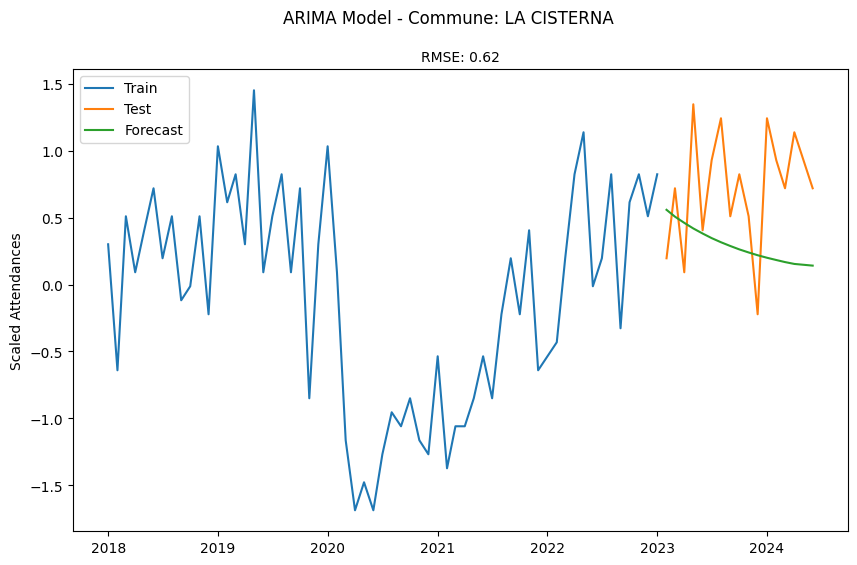

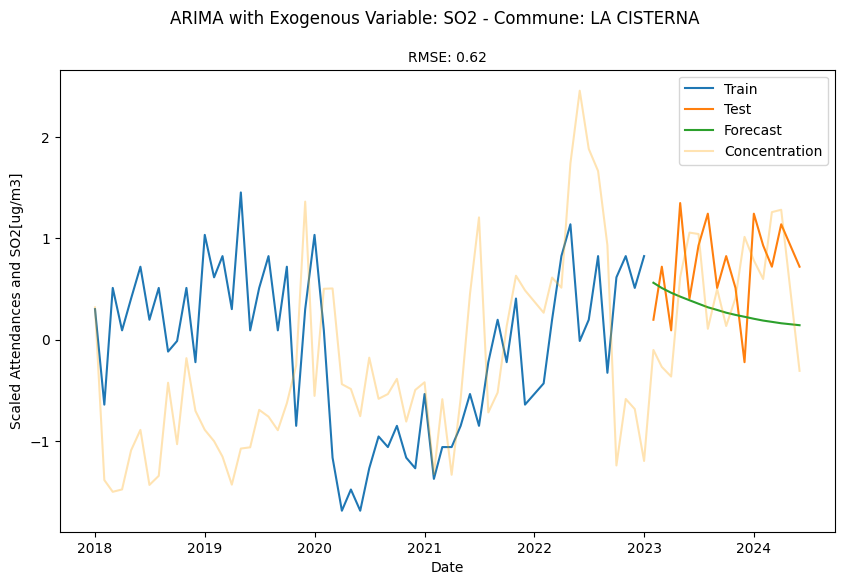

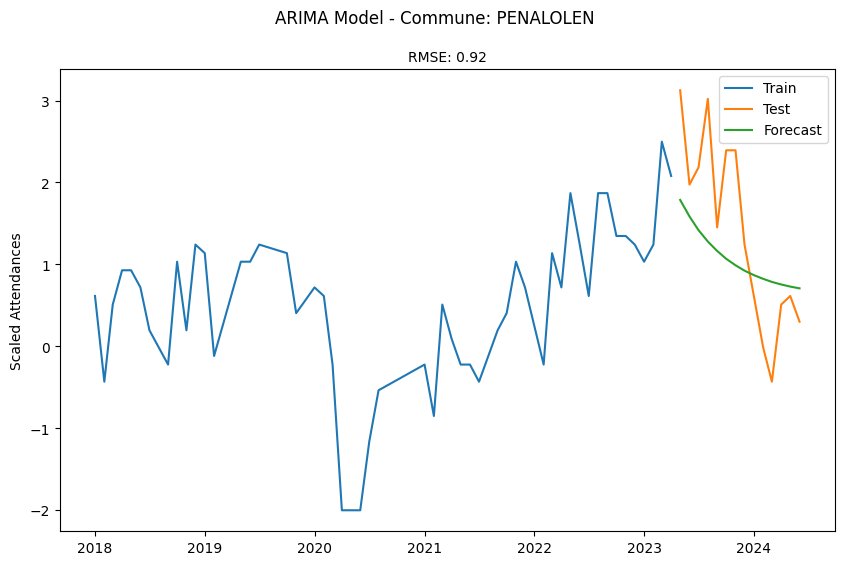

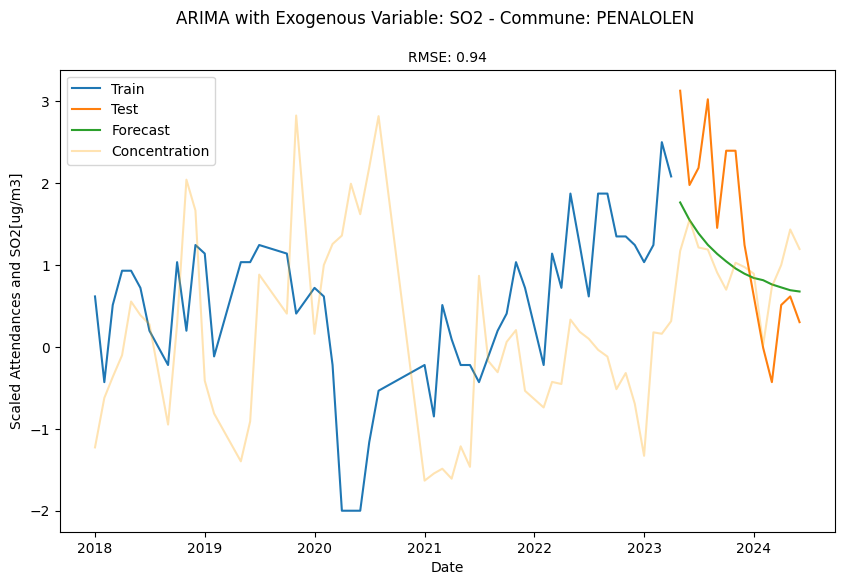

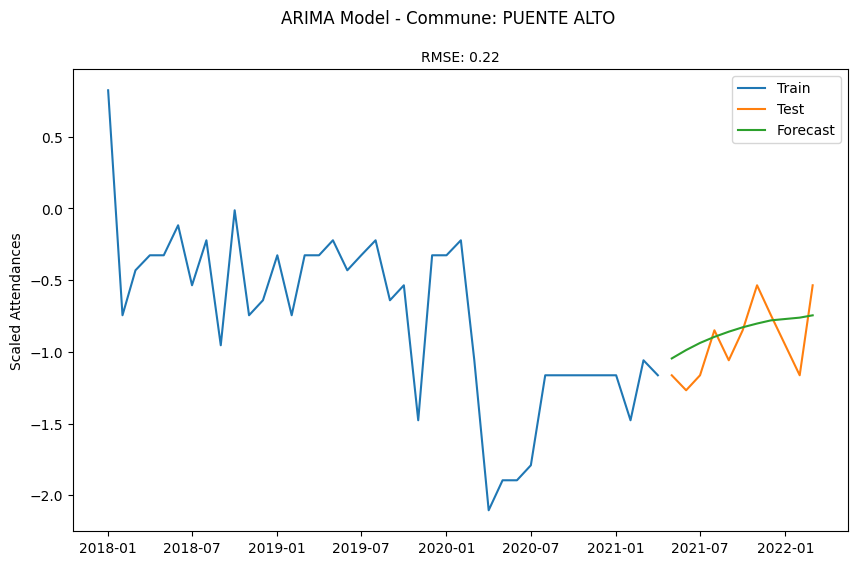

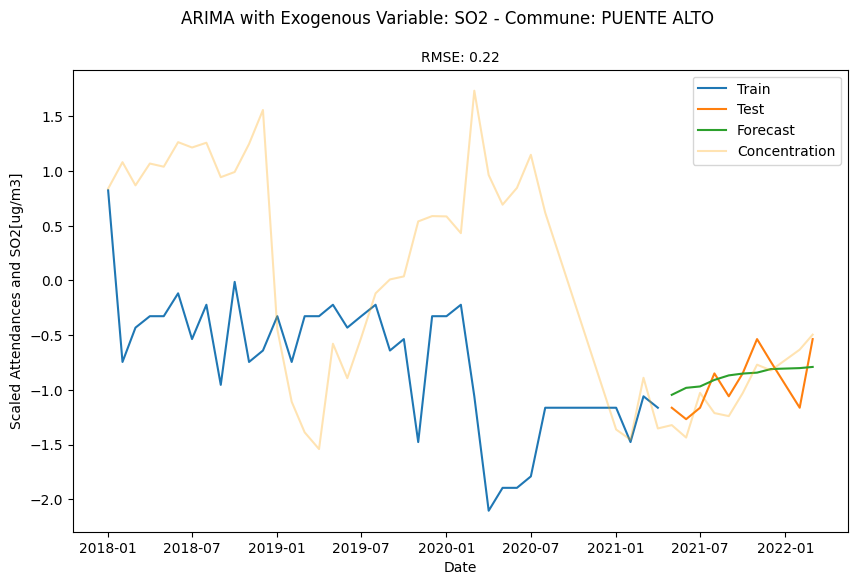

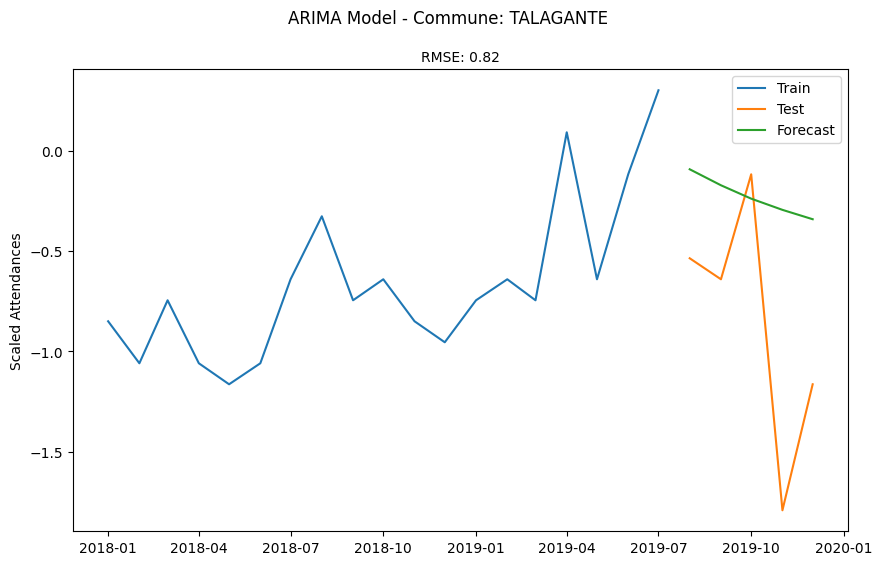

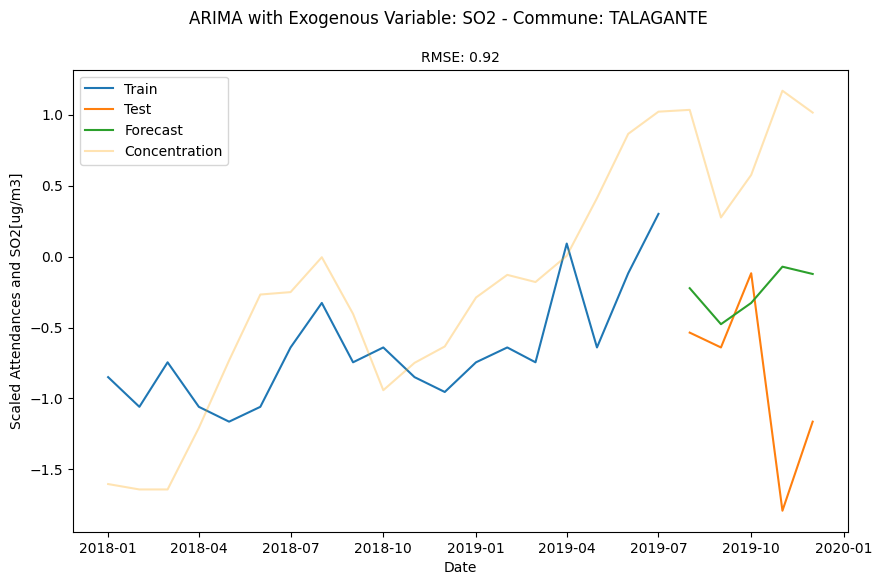

In [32]:
# loop over communes
rmse_list =[]
rmse_so2_list =[]
for commune in data['commune'].unique():
    A = data[data['commune'] == commune]

    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    order = (1,0,1)

    # evaluate
    model = ARIMA(A_train['attendances'], order=order)
    model_fit = model.fit()
    rmse = root_mean_squared_error(A_test['attendances'], model_fit.forecast(steps=len(A_test)))
    rmse_list.append(rmse)

    # plot
    plt.figure(figsize=(10,6))
    plt.suptitle('ARIMA Model - Commune: ' + commune)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.ylabel('Scaled Attendances')
    plt.plot(A_train.index, A_train['attendances'], label='Train')
    plt.plot(A_test.index, A_test['attendances'], label='Test')
    # graph train forecast
    plt.plot(A_test.index, model_fit.forecast(steps=len(A_test)), label='Forecast')
    plt.legend()
    plt.savefig(f'img/arima_{commune}.png')

    # multi-feature ARIMA per commune
    model = ARIMA(A_train['attendances'], exog=A_train[['concentration']], order=order)
    model_fit = model.fit()

    # evaluate
    rmse = root_mean_squared_error(A_test['attendances'], model_fit.forecast(steps=len(A_test), exog=A_test[['concentration']]))
    rmse_so2_list.append(rmse)

    # plot
    plt.figure(figsize=(10,6))
    plt.suptitle('ARIMA with Exogenous Variable: SO2 - Commune: ' + commune)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Scaled Attendances and SO2[ug/m3]')
    plt.plot(A_train.index, A_train['attendances'], label='Train')
    plt.plot(A_test.index, A_test['attendances'], label='Test')
    # plot train forecast
    plt.plot(A_test.index, model_fit.forecast(steps=len(A_test), exog=A_test[['concentration']]), label='Forecast')
    # plot concentration
    plt.plot(A.index, A['concentration'], label='Concentration', color='orange', alpha=0.3)
    plt.legend()
    plt.savefig(f'img/arima_{commune}_so2.png')

print(f'Average RMSE without SO2: {sum(rmse_list)/len(rmse_list):<.2f}')
print(f'Average RMSE with SO2: {sum(rmse_so2_list)/len(rmse_so2_list):<.2f}')
